## Setting Up

### Import packages here

In [1]:
import pickle
import glob as gl
from numpy import isnan, append, linspace, datetime64
from xarray import concat, open_dataset
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import colorbar, colors
import cmocean
from cartopy.crs import PlateCarree 
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from postprocessing.timeseries import extract_daily_timeseries_global

# some parameters
plt.rcParams.update({'font.size': 14})
dpi = 200

### Some functions for dealing with the output files

In [2]:
def get_full_name(run_numbers,prefix):
    runs_full_name = []
    for run in run_numbers:
        runs_full_name.append(prefix + str(run))
    return runs_full_name

In [3]:
def get_wrf_lists(run_numbers,prefix):
    wrf_lists = []
    for rdx,run in enumerate(run_numbers):
        wfv_dir = proj_dir + prefix + str(run) + '/'
        wrf_list = gl.glob(wfv_dir + 'output_wrf/cstm_d01*')
        if not wrf_list:
            wfv_dir = proj_dir + prefix + str(run).rjust(2,'0') + '/'
            wrf_list = gl.glob(wfv_dir + 'output_wrf/cstm_d01*')  
        wrf_list.sort()
        wrf_lists.append(wrf_list)
        if rdx == 0:
            print(wrf_list[0:2])
            
    return wrf_lists

In [4]:
def get_fvcom_lists(run_numbers,prefix):
    fv_lists = []
    for rdx,run in enumerate(run_numbers):
        wfv_dir = proj_dir + prefix + str(run) + '/'
        fv_list = gl.glob(wfv_dir + 'output_fvcom*/gl_0*.nc')
        if not fv_list:
            wfv_dir = proj_dir + prefix + str(run).rjust(2,'0') + '/'
            fv_list = gl.glob(wfv_dir + 'output_fvcom*/gl_0*.nc')
        fv_list.sort()
        fv_lists.append(fv_list)
        if rdx == 0:
            print(fv_list[0:2])
        
    return fv_lists

### Set the directories and get list of filenames

In [5]:
# start and end of analysis
ts = datetime64('2018-06-01') 
te = datetime64('2018-09-01')

# SET OWN PROJECT DIRECTORY HERE
proj_dir = '/lus/eagle/projects/COMPASS-GLM/'

# filenames
proj_dir = proj_dir + 'WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/' # wrf + fvcom coupled

# information of the different sets (training, test, and bayesian optimized)
run_numbers = range(1,19)
train_dict = {'run_numbers': run_numbers,
              'run_names': get_full_name(run_numbers=run_numbers,prefix='9_variable_korobov_'),
              'wrf_lists': get_wrf_lists(run_numbers=run_numbers,prefix='trainK18/run'),
              'fvcom_lists': get_fvcom_lists(run_numbers=run_numbers,prefix='trainK18/run'),
              'output_filename': '../output/wfv_global_daily_temperature_training_set.pkl'}
run_numbers = range(1,10)
test_dict = {'run_numbers': run_numbers,
             'run_names': get_full_name(run_numbers=run_numbers,prefix='9_variable_latin_hypercube'),
             'wrf_lists': get_wrf_lists(run_numbers=run_numbers,prefix='testLH9/test'), #korobov_run'),
             'fvcom_lists': get_fvcom_lists(run_numbers=run_numbers,prefix='testLH9/test'),
             'output_filename': '../output/wfv_global_daily_temperature_test_set.pkl'}

set_dict = {'training_set': train_dict,
            'test_set': test_dict}

all_output_filename = '../output/wfv_global_daily_temperatures_all_processed.pkl'

['/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/trainK18/run01/output_wrf/cstm_d01_2018-05-12_00:00:00', '/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/trainK18/run01/output_wrf/cstm_d01_2018-05-12_01:00:00']
['/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/trainK18/run01/output_fvcom0/gl_0001.nc', '/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/trainK18/run01/output_fvcom0/gl_0002.nc']
['/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test01/output_wrf/cstm_d01_2018-05-12_00:00:00', '/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test01/output_wrf/cstm_d01_2018-05-12_01:00:00']
['/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test01/output_fvcom/gl_0001.nc', '/lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test01/output_fvcom/gl_0002

## Processing

In [8]:
# choose which set to do..
#this_list = set_dict['training_set']
this_list = set_dict['test_set']

### Get timeseries of WRF+FVCOM daily temperatures globally

In [13]:
wfv_runs = {'runs': this_list['run_names'],
            'LST': [],
            'T2': []}

In [14]:
wfv_runs['LST'] = extract_daily_timeseries_global(this_list['fvcom_lists'], 
                                                  file_type='fvcom', 
                                                  variable_name='LST')

processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test01/output_fvcom/gl_0001.nc
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test02/output_fvcom/gl_0001.nc
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test03/output_fvcom/gl_0001.nc
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test04/output_fvcom/gl_0001.nc
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test05/output_fvcom0/gl_0001.nc
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test06/output_fvcom0/gl_0001.nc
processing new model run, first file name: /lus/eagle/pr

In [12]:
wfv_runs['T2'] = extract_daily_timeseries_global(this_list['wrf_lists'], 
                                                 file_type='wrf', 
                                                 variable_name='T2')

processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test01/output_wrf/cstm_d01_2018-05-12_00:00:00
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test02/output_wrf/cstm_d01_2018-05-12_00:00:00
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test03/output_wrf/cstm_d01_2018-05-12_00:00:00
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test04/output_wrf/cstm_d01_2018-05-12_00:00:00
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test05/output_wrf/cstm_d01_2018-05-12_00:00:00
processing new model run, first file name: /lus/eagle/projects/COMPASS-GLM/WRF+FVCOM_Sensitivity/Summer_2018_Ensemble/testLH9/test06/ou

In [13]:
# save into pickle file
with open(this_list['output_filename'], 'wb') as fp:
    pickle.dump(wfv_runs, fp)
    print('Written data into the output binary file')

Written data into the output binary file


In [14]:
# open the existing file
with open(this_list['output_filename'], 'rb') as fp:
    wfv_runs = pickle.load(fp)

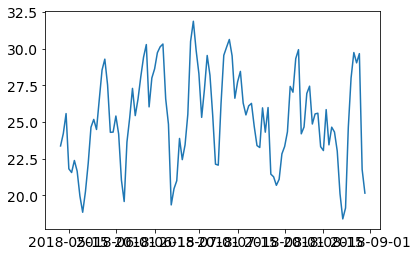

In [15]:
plt.plot(wfv_runs['T2'][0][0],wfv_runs['T2'][0][1][:,100,100])
#plt.plot(wfv_runs_train['T2'][4][0],wfv_runs_train['T2'][4][1][:,100,100])

## Plotting for checking

### Plot ensemble of WRF T2

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


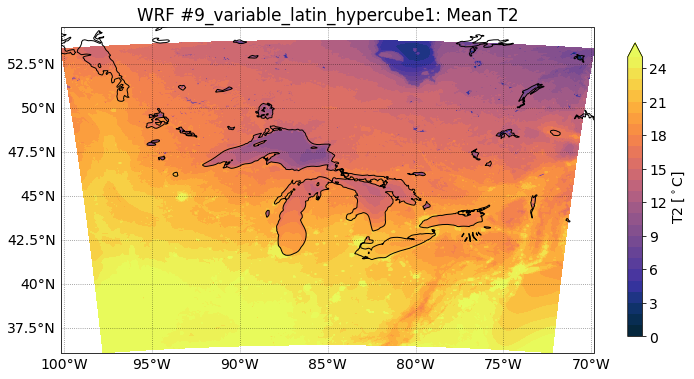

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


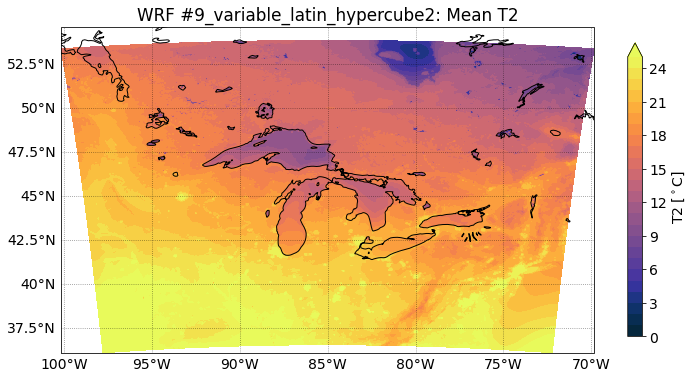

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


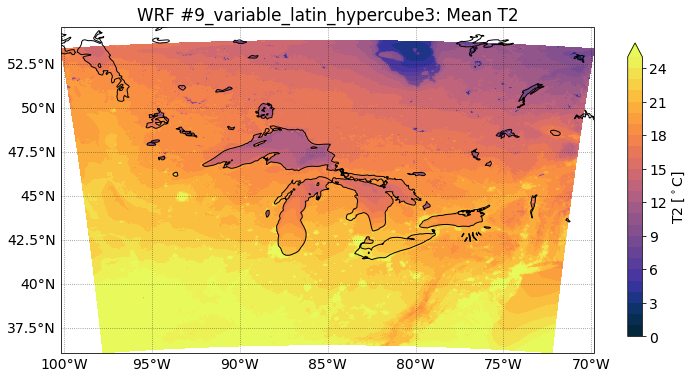

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


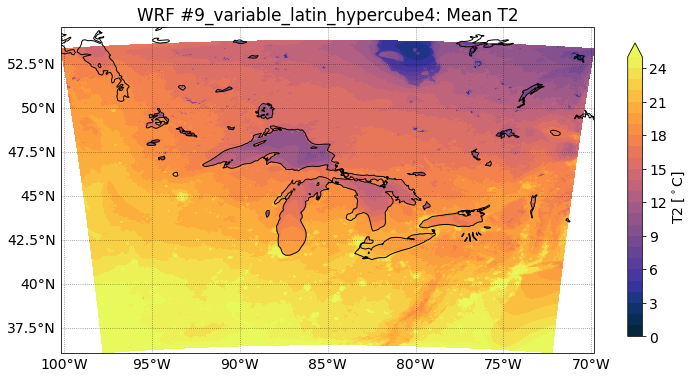

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


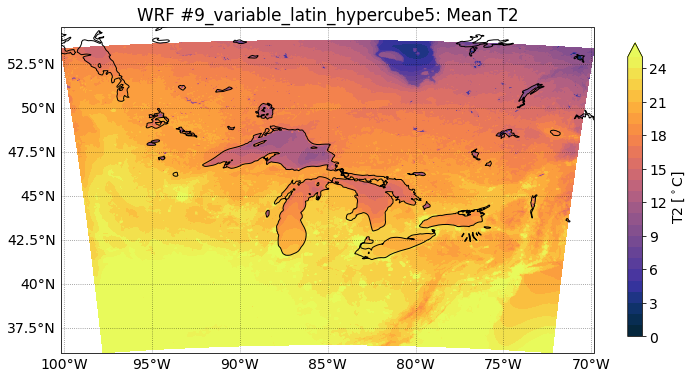

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


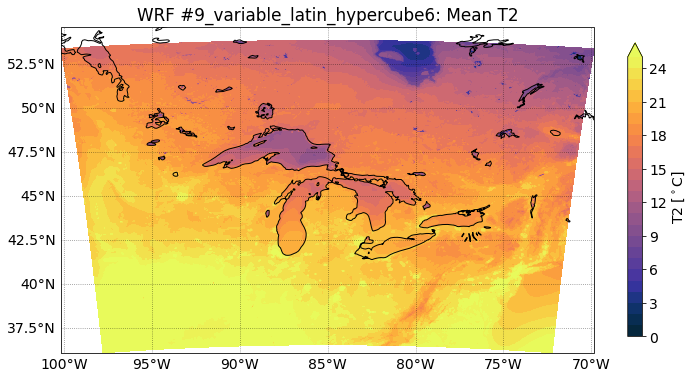

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


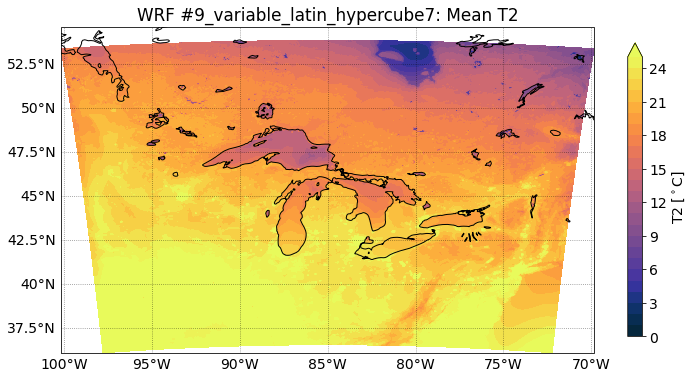

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


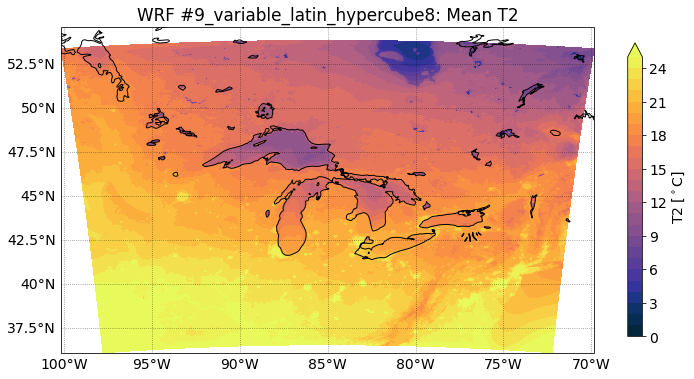

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


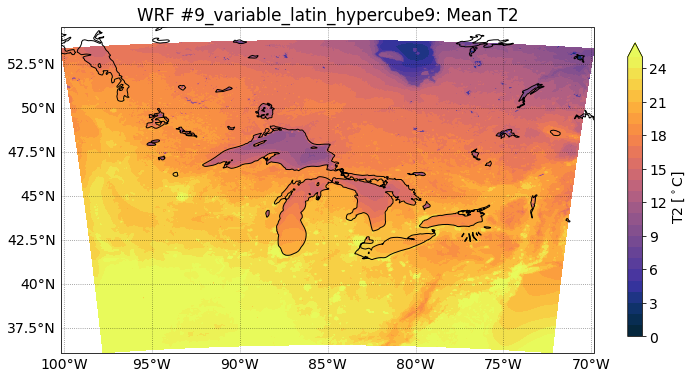

In [16]:
## WRF mean T2

# Create a figure
for rdx, wfv_run in enumerate(wfv_runs['T2']):
    
    wrf_T2 = wfv_run[1]
    
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=PlateCarree())
    ax.set_extent([wrf_T2.XLONG.min(), 
               wrf_T2.XLONG.max(), 
               wrf_T2.XLAT.min(), 
               wrf_T2.XLAT.max()])

    # Download and add the states and coastlines
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)

    # Set color range
    vmin = 0
    vmax = 25
    levels = 25
    contour_levels = linspace(vmin,vmax,levels+1)

    # Plot the results
    plt.contourf(wrf_T2.XLONG, 
                 wrf_T2.XLAT, 
                 wrf_T2.mean(dim='time'),
                 levels=contour_levels, extend='max',
                 transform= PlateCarree(),
                 cmap=cmocean.cm.thermal)

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.9, label='T2 [$^\circ$C]')

    # Add the gridlines
    gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gll.xlabels_top = None
    gll.ylabels_right = None
    gll.xformatter = LONGITUDE_FORMATTER
    gll.yformatter = LATITUDE_FORMATTER

    plt.title("WRF #" + wfv_runs['runs'][rdx] + ": Mean T2")

    plt.show()

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


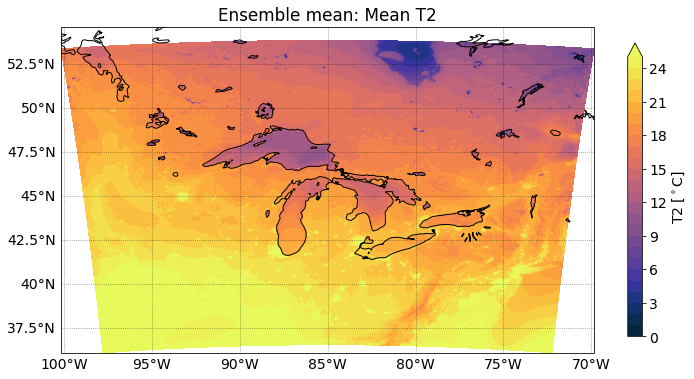

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


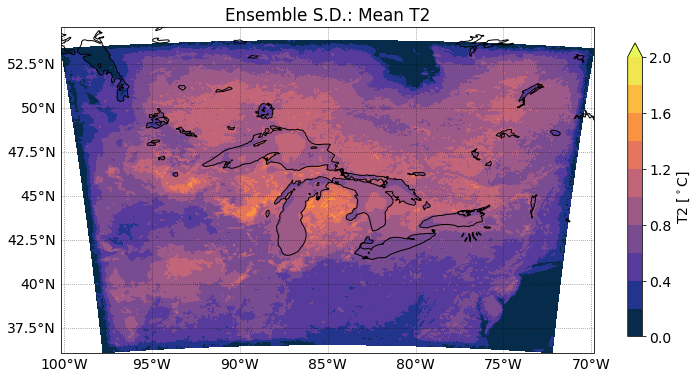

In [17]:
## WRF mean T2
for rdx, wfv_run in enumerate(wfv_runs['T2']):
    wfv_temp = wfv_run[1].mean(dim='time')
    if rdx == 0:
        wrf_T2 = wfv_temp
    else:
        wrf_T2 = concat([wrf_T2,wfv_temp],'time')
    
for idx in range(2):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=PlateCarree())
    ax.set_extent([wrf_T2.XLONG.min(), 
               wrf_T2.XLONG.max(), 
               wrf_T2.XLAT.min(), 
               wrf_T2.XLAT.max()])

    # Download and add the states and coastlines
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)

    # Set color range
    vmin = 0
    vmax = 25 if idx == 0 else 2
    levels = 25 if idx == 0 else 10
    contour_levels = linspace(vmin,vmax,levels+1)

    # Plot the results
    plt.contourf(wrf_T2.XLONG, 
                 wrf_T2.XLAT, 
                 wrf_T2.mean(dim='time') if idx == 0 else wrf_T2.std(dim='time'),
                 levels=contour_levels, extend='max',
                 transform=PlateCarree(),
                 cmap=cmocean.cm.thermal)

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.9, label='T2 [$^\circ$C]')

    # Add the gridlines
    gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gll.xlabels_top = None
    gll.ylabels_right = None
    gll.xformatter = LONGITUDE_FORMATTER
    gll.yformatter = LATITUDE_FORMATTER

    title_string = "Ensemble mean: Mean T2" if idx == 0 else "Ensemble S.D.: Mean T2"
    plt.title(title_string)

    plt.show()

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


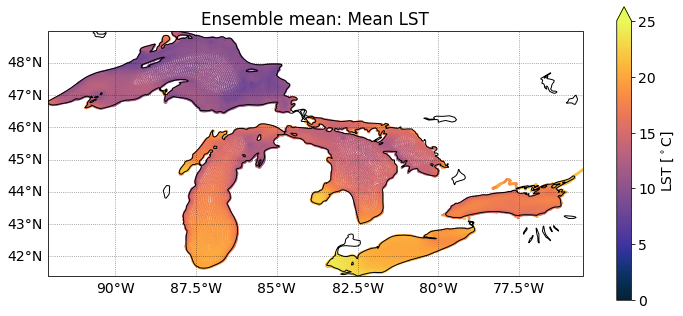

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


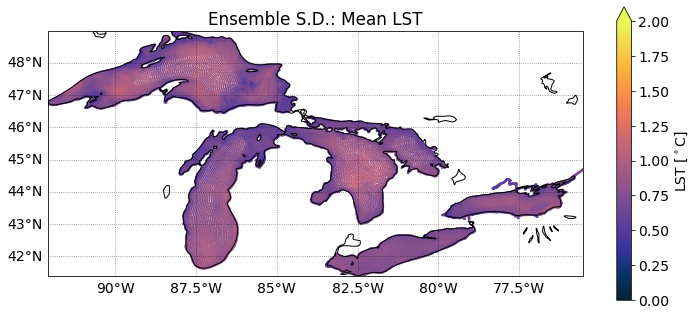

In [18]:
## FVCOM mean LST
for rdx, wfv_run in enumerate(wfv_runs['LST']):
    wfv_temp = wfv_run[1].mean(dim='time')
    if rdx == 0:
        fv_LST = wfv_temp
    else:
        fv_LST = concat([fv_LST,wfv_temp],'time')
    
for idx in range(2):
    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=PlateCarree())
    ax.set_extent([fv_LST.lon.min(), 
               fv_LST.lon.max(), 
               fv_LST.lat.min(), 
               fv_LST.lat.max()])

    # Download and add the states and coastlines
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)

    # Set color range
    vmin = 0
    vmax = 25 if idx == 0 else 2
    levels = 25 if idx == 0 else 10
    contour_levels = linspace(vmin,vmax,levels+1)

    # Plot the results
    plt.scatter(fv_LST.lon, 
            fv_LST.lat, 
            c=fv_LST.mean(dim='time') if idx == 0 else fv_LST.std(dim='time'),
            s=1, 
            vmin=vmin, vmax=vmax,
            transform=PlateCarree(),
            cmap=cmocean.cm.thermal)

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.9, label='LST [$^\circ$C]', extend='max')

    # Add the gridlines
    gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gll.xlabels_top = None
    gll.ylabels_right = None
    gll.xformatter = LONGITUDE_FORMATTER
    gll.yformatter = LATITUDE_FORMATTER

    title_string = "Ensemble mean: Mean LST" if idx == 0 else "Ensemble S.D.: Mean LST"
    plt.title(title_string)

    plt.show()
    

## Combine results and process to get right timeseries window

In [19]:
# construct the training data into right dimensions
for this_dict in set_dict.values():
    # already exists..
    with open(this_dict['output_filename'], 'rb') as fp:
        wfv_runs = pickle.load(fp)
        
    print(f'processing timeseries in this file: {this_dict["output_filename"]}')

    for rdx, run in enumerate(wfv_runs['LST']):
        tdx = (run[0] >= ts) & (run[0] < te)
        value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
        if rdx == 0:
            trainY = value_temp
            this_dict['lake_time'] = run[0][tdx]
            this_dict['lake_lon'] = run[1].lon
            this_dict['lake_lat'] = run[1].lat
        else:
            trainY = append(trainY,value_temp,axis=0)
    display(trainY.shape)
    
    this_dict['LST'] = trainY  
    
    for rdx, run in enumerate(wfv_runs['T2']):
        tdx = (run[0] >= ts) & (run[0] < te)
        value_temp = run[1].isel(time=tdx).values.reshape(1,-1)
        if rdx == 0:
            trainY = value_temp
            this_dict['air_time'] = run[0][tdx]
            this_dict['air_lon'] = run[1].XLONG
            this_dict['air_lat'] = run[1].XLAT
        else:
            trainY = append(trainY,value_temp,axis=0)
    display(trainY.shape)
    
    this_dict['T2'] = trainY  

processing timeseries in this file: ../output/wfv_global_daily_temperature_training_set.pkl


(18, 3288908)

(18, 23915892)

processing timeseries in this file: ../output/wfv_global_daily_temperature_test_set.pkl


(9, 3288908)

(9, 23915892)

In [20]:
with open(all_output_filename, 'wb') as fp:
    pickle.dump(set_dict, fp)
    print('Written all processed data into the output binary file')

Written all processed data into the output binary file


## Visualize spatiotemporal modes of variation (PCA)

In [21]:
trainY = set_dict['training_set']['LST']
testY = set_dict['test_set']['LST']

In [22]:
# Decompose the spatiotemporal series using PCA/KL
var_explained = 0.90 #for PCA
random_seed = 222
pca_obj = PCA(n_components=var_explained, random_state=random_seed, whiten=True)
pca_obj.fit(trainY)

PCA(n_components=0.9, random_state=222, whiten=True)

In [23]:
set_dict['training_set']['LST'].shape

(18, 3288908)

In [59]:
# get the outputs from the PCA
klxi_train = pca_obj.transform(trainY)
klxi_test  = pca_obj.transform(testY)
eigenratio = pca_obj.explained_variance_ratio_
print(eigenratio)
neig = pca_obj.n_components_
print(f'number of eigenmodes is {neig}')

[0.59524146 0.10616204 0.04990378 0.04276877 0.03184092 0.0306296
 0.02111236 0.0180193  0.01771278]
number of eigenmodes is 9


/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


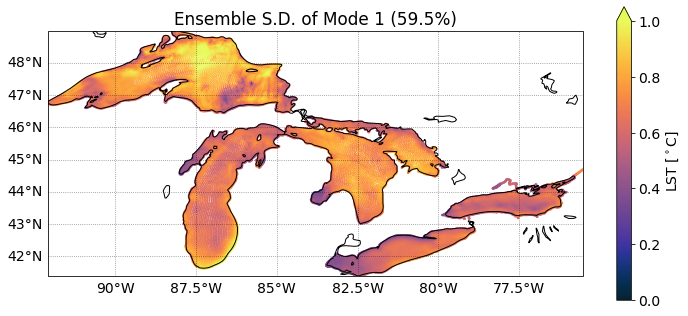

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


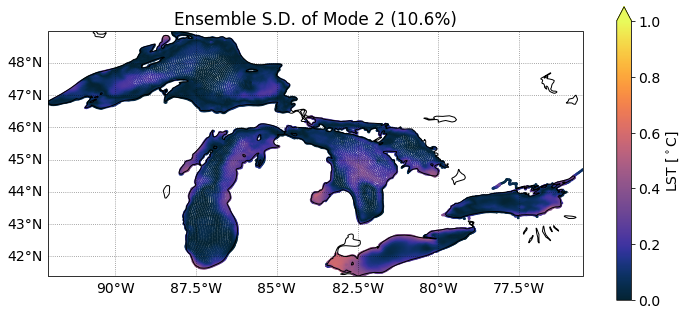

/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/wpringle/.conda/envs/wrf-env/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


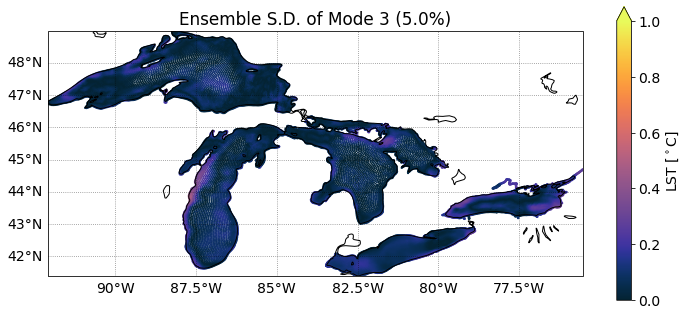

In [64]:
#plot selected mode of variation
Ymean = trainY.mean(axis=0)

for mode in range(3):
    value = (trainY - Ymean) @ pca_obj.components_[mode]
    pc_mode_ens = value.reshape(-1,1) @ pca_obj.components_[mode].reshape(1,-1)
    pc_mode_ens = pc_mode_ens.reshape(value.shape[0],-1,len(set_dict['training_set']['lake_lon']))
    pc_mode_ens = pc_mode_ens.mean(axis=1)

    fig = plt.figure(figsize=(12,6))
    ax = plt.axes(projection=PlateCarree())
    ax.set_extent([set_dict['training_set']['lake_lon'].min(), 
               set_dict['training_set']['lake_lon'].max(), 
               set_dict['training_set']['lake_lat'].min(), 
               set_dict['training_set']['lake_lat'].max()])

    # Download and add the states and coastlines
    lakes = NaturalEarthFeature(
            category='physical',
            name='lakes',
            facecolor='none',
            scale='50m')
    ax.add_feature(lakes)

    # Set color range
    vmin = 0
    vmax = +1

    # Plot the results
    plt.scatter(set_dict['training_set']['lake_lon'], 
            set_dict['training_set']['lake_lat'], 
            c=pc_mode_ens.std(axis=0),
            s=1, 
            vmin=vmin, vmax=vmax,
            transform=PlateCarree(),
            cmap=cmocean.cm.thermal)

    # Add a color bar
    plt.colorbar(ax=ax, shrink=.9, label='LST [$^\circ$C]', extend='max')

    # Add the gridlines
    gll = ax.gridlines(color="black", linestyle="dotted", draw_labels=True, alpha=0.5)
    gll.xlabels_top = None
    gll.ylabels_right = None
    gll.xformatter = LONGITUDE_FORMATTER
    gll.yformatter = LATITUDE_FORMATTER

    title_string = f"Ensemble S.D. of Mode {mode+1} ({eigenratio[mode]*100:.1f}%)"
    plt.title(title_string)

    plt.show()

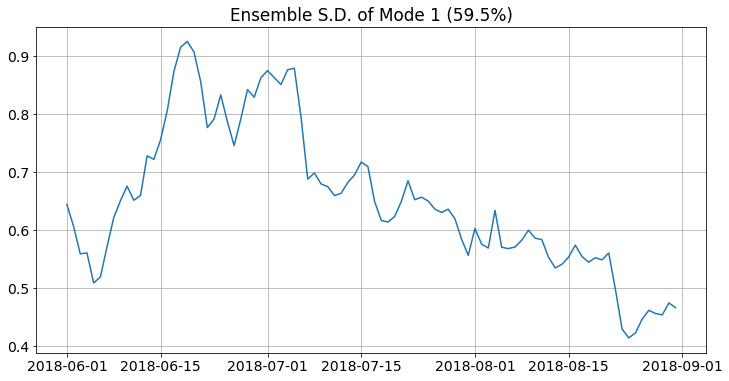

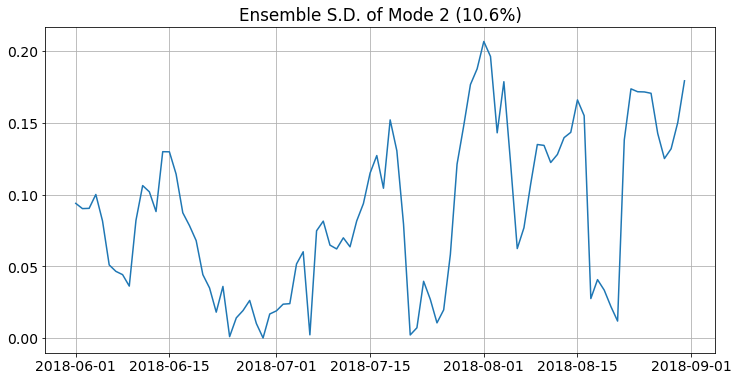

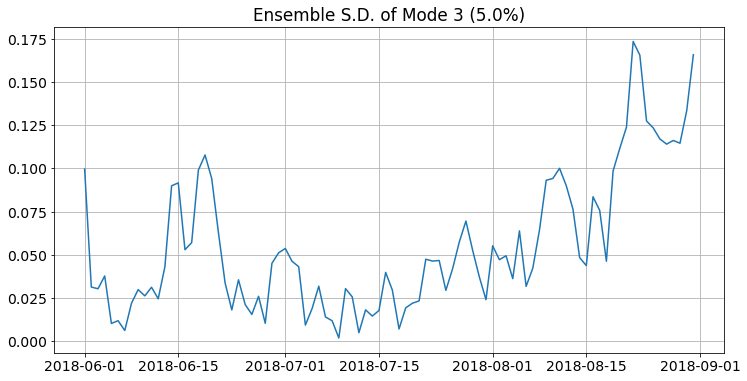

In [67]:
#plot selected mode of variation
Ymean = trainY.mean(axis=0)

for mode in range(3):
    value = (trainY - Ymean) @ pca_obj.components_[mode]
    pc_mode_ens = value.reshape(-1,1) @ pca_obj.components_[mode].reshape(1,-1)
    pc_mode_ens = pc_mode_ens.reshape(-1,
                                      len(set_dict['training_set']['lake_time']),
                                      len(set_dict['training_set']['lake_lon']))
    pc_mode_ens = pc_mode_ens.mean(axis=2)

    fig = plt.figure(figsize=(12,6))
    plt.plot(set_dict['training_set']['lake_time'],pc_mode_ens.std(axis=0))

    title_string = f"Ensemble S.D. of Mode {mode+1} ({eigenratio[mode]*100:.1f}%)"
    plt.title(title_string)
    plt.grid()
    plt.show()

In [68]:
pc_mode_ens.shape

(18, 92)